In [2]:
import pandas as pd

In [3]:
owid_covid = pd.read_csv("https://covid.ourworldindata.org/data/owid-covid-data.csv")
owid_covid["date"]=pd.to_datetime(owid_covid["date"])
df=owid_covid[owid_covid.location=="France"].set_index("date", drop=True).resample('D').interpolate(method='linear').reset_index()

In [10]:
from sklearn.base import TransformerMixin, BaseEstimator

class DateFeatures(TransformerMixin, BaseEstimator):
    features=[
        "hour",
        "year",
        "day",
        "weekday",
        "month",
        "quarter",
    ]

    def __init__(self):
        super().__init__()
        self.feature_names: List[str] = []

    def transform(self, df: pd.DataFrame):
        Xt = []
        for col in df.columns:
            for feature in self.features:
                date_feature = getattr(
                    getattr(
                        df[col], "dt"
                    ), feature
                )
                date_feature.name = f"{col}_{feature}"
                Xt.append(date_feature)
        df2 = pd.concat(Xt, axis=1)
        return df2

    def fit(self, df: pd.DataFrame, y=None, **fit_params):
        return self

#### DateFeatures transformer annotates a dataset according to date

In [21]:
import numpy as np
from typing import Dict

class CyclicalFeatures(TransformerMixin, BaseEstimator):
    # "" CyclicalFeatures transformer. """

    def __init__(self, max_vals: Dict[str, float] = {}):
        # Nothing much to to.
        super().__init__()
        self.feature_names: List[str] = []
        self.max_vals = max_vals
    
    def get_feature_names(self):
        # Feature names.
        return self.feature_names

    def transform(self, df: pd.DataFrame):
        # Annotate date features.
        Xt = []
        for col in df.columns:
            if col in self.max_vals:
                max_val = self.max_vals[col]
            else:
                max_val = df[col].max()
            for fun_name, fun in [("cos", np.cos), ("sin", np.sin)]:
                date_feature = fun(2*np.pi*df[col]/max_val)
                date_feature.name = f"{col}_{fun_name}"
                Xt.append(date_feature)

        df2=pd.concat(Xt, axis=1)
        self.feature_names=list(df2.columns)
        return df2

    def fit(self, df: pd.DataFrame, y=None, **fit_params):
        # No fitting needed.
        return self

### Apply transformer to the date column of the DataFrame.

In [14]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline
preprocessor = ColumnTransformer(
    transformers=[(
        "date",
        make_pipeline(
            DateFeatures(),
            ColumnTransformer(transformers=[
                ("cyclical", CyclicalFeatures(),
                 ["date_day", "date_weekday", "date_month"]
                )
            ], remainder="passthrough")
        ), ["date"],
    ),], remainder="passthrough"
)

Define a pipeline of these preprocessing steps together with a model so that it
can be fitted and applied to prediction

In [15]:
from xgboost import XGBRegressor
pipeline = Pipeline(
    [
        ("preprocessing", preprocessor),
        ("xgb", XGBRegressor(objective="reg:squarederror", n_estimators=1000))
    ]
)

In [16]:
TRAIN_SIZE = int(len(df)*0.9)
HORIZON = 1
TARGET_COL = "new_cases"

In [17]:
X_train, X_test = df.iloc[HORIZON:TRAIN_SIZE], df.iloc[TRAIN_SIZE+HORIZON:]
y_train = df.shift(periods=HORIZON).iloc[HORIZON:TRAIN_SIZE][TARGET_COL]
y_test = df.shift(periods=HORIZON).iloc[TRAIN_SIZE+HORIZON:][TARGET_COL]

In [25]:
FEATURE_COLS = ["date"]
pipeline.fit(X_train[FEATURE_COLS], y_train)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('date',
                                                  Pipeline(steps=[('datefeatures',
                                                                   DateFeatures()),
                                                                  ('columntransformer',
                                                                   ColumnTransformer(remainder='passthrough',
                                                                                     transformers=[('cyclical',
                                                                                                    CyclicalFeatures(),
                                                                                                    ['date_day',
                                                                                                     'date_weekday',
                                                                                                     'date_month'])]))]),
                                                  ['date'])])),
                ('xgb',
                 XGBRegressor(base_score=None, b...
                              feature_types=None, gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=None,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=None, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=1000, n_jobs=None,
                              num_parallel_tree=None, random_state=None, ...))])

In [26]:
MAX_HORIZON=90
X_test_horizon = pd.Series(pd.date_range(
    start=df.date.min(),
    periods=len(df)+MAX_HORIZON,
    name="date"
)).reset_index()

In [27]:
forecasted=pd.concat(
    [pd.Series(pipeline.predict(X_test_horizon[FEATURE_COLS])),
     pd.Series(X_test_horizon.date)],
    axis=1
)
forecasted.columns=[TARGET_COL,"date"]

In [28]:
actual=pd.concat(
    [pd.Series(df[TARGET_COL]), pd.Series(df.date)],
    axis=1
)
actual.columns=[TARGET_COL, "date"]

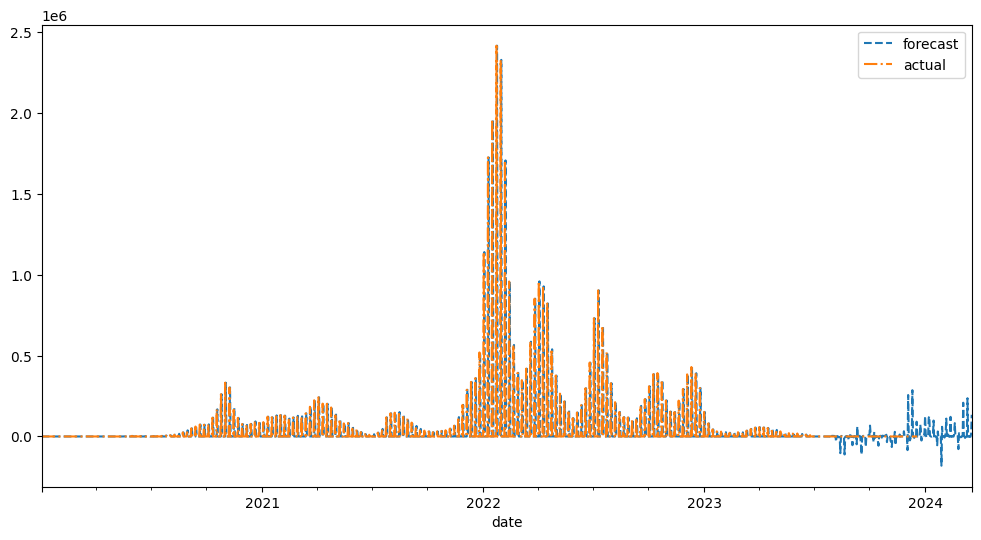

In [31]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(12,6))
forecasted.set_index("date").plot(linestyle="--", ax=ax)
actual.set_index("date").plot(linestyle="-.", ax=ax)
plt.legend(["forecast", "actual"])

In [34]:
from sklearn.metrics import mean_squared_error

test_data = actual.merge(forecasted, on="date", suffixes=("_actual", "_predicted"))
mse = mean_squared_error(test_data.new_cases_actual, test_data.new_cases_predicted,squared=False)
print("The root mean squared error (RMSE) on test set: {:.2f}".format(mse))

The root mean squared error (RMSE) on test set: 217020.85
